# **Building a Linear Heatmap for Routes**

## Problem Statement:

A logistics company in the United States asked me to create an interactive Linear Heatmap (HTML) of their delivery routes to see which Roads are highly used.
The delivery route data was incomplete, as it only contains the source and Target  Coordinate points and does not contain the waypoints.<br>
After obtaining permission from the company, I took a small sample of this data and will explain here how to extract waypoints and build Linear Heatmap step by step.<br>
check the data in  file  "PH_routes_sample.csv".  contains some routes  in Philadelphia.<br>
"plat" and "plon" columns represents the lat and lon coordinates of the source point.<br>
"dlat" and "dlon" columns represents the lat and lon coordinates of the target point.

## Steps of Extracting Waypoints

### Step 1 : Download the driving map of Philadelphia from OpenStreetMap API

In [ ]:
# step 1.1 install OpenStreetMap API
!pip install osmnx

In [ ]:
# step 1.2 download the Philadelphia graph  and save  it in Graphml file
# this cell take about 5 minutes
import osmnx as ox

ox.config(log_console=True, use_cache=True)
#download the drive graph
G = ox.graph_from_place("Philadelphia, Pennsylvania, USA", network_type='drive')

# Specify the file path where you want to save the graph
file_path = 'PH_drive_network.graphml'

# Save the graph to a GraphML file
ox.save_graphml(G, filepath=file_path)


### Step 2 : Extract the Waypoints from the Downloded Graph  

In [ ]:
# step 2.1 install the important libs
!pip install pandas
!pip install networkx

In [ ]:
# step 2.2  Extract the waypoints
import osmnx as ox
import pandas as pd
import networkx as nx
import json

count=[]
routes_inedx={}

df = pd.read_csv('PH_route_sampl.csv')
print(df.head())

file_path = 'PH_drive_network.graphml'

# Load the graph from the GraphML file
G = ox.load_graphml(filepath=file_path)

lono=df['plon'].tolist()
lato= df['plat'].tolist()
lond=  df['dlon'].tolist()
latd= df['dlat'].tolist()
#findin the nerast osmnx node to the source and target points
orig_node = ox.nearest_nodes(G, lono,lato)
dest_node = ox.nearest_nodes(G,lond ,latd)

#extract the routes with its waypoints
for i in range(len(orig_node)) :
      try:
          route= nx.astar_path(G, orig_node[i], dest_node[i], weight='length')
          print(i, '  count of the route waypoints:  ', len(route))

          routes_inedx[str(i)]=route

      except nx.exception.NetworkXNoPath:
          print('No route')
          count.append(1)

print('no route: ',len(count))
# save
with open('PH_routes_backup.json', 'w') as f:
    json.dump(routes_inedx, f)

## Steps of building Heatmap

### Step 1: Simplify the Graph file

by using the extracted waypoints, we can simplify the graphml file by deleting all points and edges are not available in the extracted waypoints.

In [ ]:

with open('PH_routes_backup.json', 'r') as f:
    routes_inedx= json.load(f)

# obtain nested list of all routes
routes_only=[]
for key in routes_inedx:
    routes_only.append(routes_inedx[key])
print(len(routes_only))

# define all nodes and edges thats avalible in extracted data
nodes=[]
edges=[]
for rout in routes_only:
    for node in rout:
        nodes.append(str(node))
    for i in range(len(rout)-1) :
        edge_source=rout[i]
        edge_target= rout[i+1]
        edge= (str(edge_source), str(edge_target))
        edges.append(edge)

nodes=set(nodes)
print("number of nodes : ",len(nodes))
edges= set(edges)
print("number of edges : ",len(edges))


G = nx.read_graphml('PH_drive_network.graphml')

# Define your predefined list of nodes and edges to keep
nodes_to_keep = nodes
edges_to_keep = edges

# Remove nodes not in the predefined list
nodes_to_remove = [node for node in G.nodes() if node not in nodes_to_keep]
G.remove_nodes_from(nodes_to_remove)

# Remove edges not in the predefined list
edges_to_remove = [(source, target) for source, target in G.edges() if (source, target) not in edges_to_keep]
G.remove_edges_from(edges_to_remove)

# Save the modified graph back to a new GraphML file
nx.write_graphml(G, 'PH_modified_graph.graphml')

Note that the simplified file size is 1.71 MB which is less than the original graph 25.25 MB

### Step 2: Find The Max Edge Used
Each graph contains nodes and edges.
An Edge is a line between two nodes.
Therefore, we will rearrange the unique edges in descending order and get what is the most used edge in our routes.<br>
Finding the maximum used edge is important in determining the transparency ratio of the routes when drawing it.

In [ ]:


with open('PH_routes_backup.json', 'r') as f:
    routes_inedx= json.load(f)

routes_only=[]
for key in routes_inedx:
    routes_only.append(routes_inedx[key])
print(len(routes_only))

# define all edges thats avalible in extracted data
edges=[]
for rout in routes_only:

    for i in range(len(rout)-1) :
        edge_source=rout[i]
        edge_target= rout[i+1]
        edge= (str(edge_source), str(edge_target))
        edges.append(edge)

#groub the edges by its "count"(frequency or number of car passed this edge)
df= pd.DataFrame(data={"edge": edges, "count": int})
df = df.groupby(['edge'], as_index=False).count()
df.sort_values(by='count', ascending=False, axis=0, inplace=True)

print(df.head())

Note that the most edge is used 4 times, so the least transparency can drown for all routes is 1/4=0.25.

 In order to understand what is happening, imagine that you have several routes, and each route contains several edges.
If you draw each route at a transparency level of 1/4, the edge that was repeated four times will be drawn four times, each time at 1/4, and the total will be 1. This means that the color will be strong, and so on with the rest of the routes.

### Step 3: Drow The Routes And Build The HTML Heatmap


In [ ]:
!pip install folium

In [ ]:
import folium

with open('PH_routes_backup.json', 'r') as f:
    routes_inedx= json.load(f)
#creat the map 
m= folium.Map(location=[39.95273220855029, -75.16527200039157], tiles= "cartodbdark_matter")
file_path = 'PH_modified_graph.graphml'

# Load the graph from the GraphML file
G = ox.load_graphml(filepath=file_path)
routes_only=[]

for key in routes_inedx:
    routes_only.append(routes_inedx[key])
#add all routes (every route with transparency of 1/4)
for  route in routes_only:
    route_map = ox.plot_route_folium(G, route, route_map=m, color='red', weight=2, opacity=1/4)
#save the map in html file
route_map.save('PH_routes_Heatmap.html')

Now, you can download the "PH_routes_Heatmap.html" file and browser the heatmap, this screenshot of it<br>
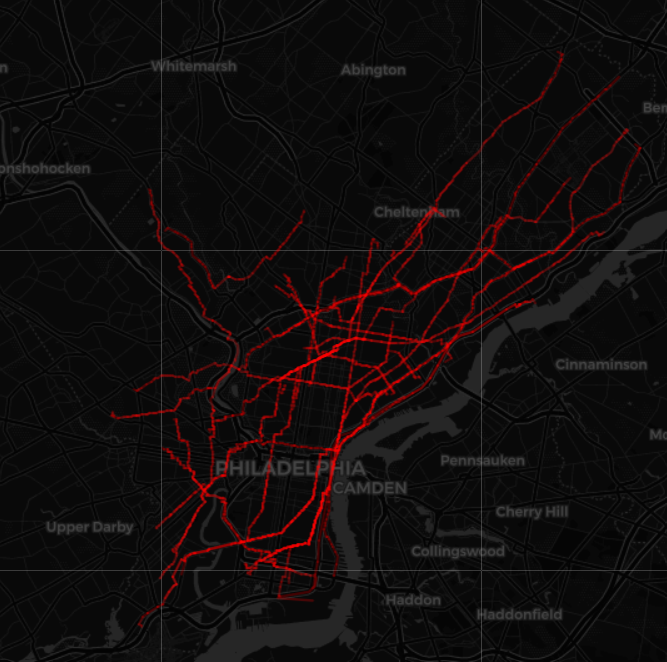

By using the same steps you can build the Florida Heatmap of "FL_routes_sample.csv" routes.

take into account that the steps of building a Florida heatmap will consume a lot of time and resources since its graph is bigger.<br>
Screenshot of Florida Heatmap:

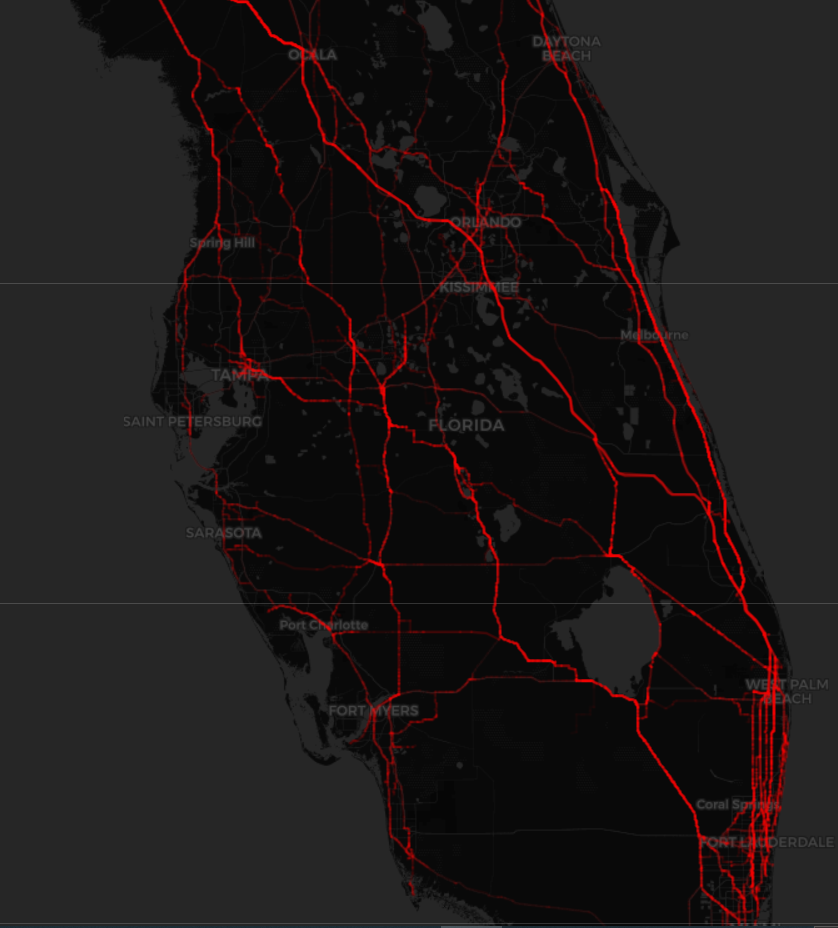

## Author
### Eng: Mohammed Almekhlafi

If you have any questions, connect and chat with me on LinkedIn:<br>
[www.linkedin.com/in/mohammed-almekhlafi-236577232](https://www.linkedin.com/in/mohammed-almekhlafi-236577232)

For more data analysis projects, follow me on Github:<br>
[https://github.com/Mohammed-Almekhlafi](https://github.com/Mohammed-Almekhlafi)